In [1]:
import numpy as np
from numpy import exp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.constants import G
from scipy.special import expi
from typing import List
import pickle
import os
from IPython.display import HTML

import pyswarms as ps

# import torch

In [2]:
PRINT_NEGA_POSI = False
INCLUDE_MG = True

In [3]:
SPARCdata = pd.read_csv("SPARC_formatted.csv")
SPARCdata[:10]

ID      D     R   Vobs  e_Vobs  Vgas  Vdisk  Vbul  SBdisk  SBbul
0    CamB   3.36  0.16   1.99    1.50  1.86   3.75   0.0   30.32    0.0
1    CamB   3.36  0.41   4.84    1.50  4.24   9.47   0.0   23.77    0.0
2    CamB   3.36  0.57   6.79    1.50  5.61  11.76   0.0   15.87    0.0
3    CamB   3.36  0.73   8.87    1.50  6.77  13.72   0.0   12.40    0.0
4    CamB   3.36  0.90  10.90    1.50  7.77  14.80   0.0    9.63    0.0
5    CamB   3.36  1.06  12.90    1.50  8.44  15.24   0.0    5.86    0.0
6    CamB   3.36  1.22  14.70    1.50  8.64  15.11   0.0    5.19    0.0
7    CamB   3.36  1.47  16.80    1.50  8.08  15.90   0.0    3.02    0.0
8    CamB   3.36  1.79  20.10    1.50  6.91  14.91   0.0    0.88    0.0
9  D512-2  15.20  0.96  22.90    2.71  4.08  14.85   0.0   16.45    0.0

In [4]:
galaxies = SPARCdata["ID"].drop_duplicates()
num_gals = len(galaxies)

num_gals, galaxies

(175,
 0           CamB
 9         D512-2
 13        D564-8
 19        D631-7
 35        DDO064
           ...   
 3309    UGC12632
 3324    UGC12732
 3340     UGCA281
 3347     UGCA442
 3355     UGCA444
 Name: ID, Length: 175, dtype: object)

In [5]:
gals_w_bulge = set(SPARCdata[SPARCdata['Vbul'] != 0]['ID'])

In [6]:
galaxy_dict = {}
for n, i in enumerate(galaxies):
    galaxy_dict[i] = n
galaxy_dict

{'CamB': 0,
 'D512-2': 1,
 'D564-8': 2,
 'D631-7': 3,
 'DDO064': 4,
 'DDO154': 5,
 'DDO161': 6,
 'DDO168': 7,
 'DDO170': 8,
 'ESO079-G014': 9,
 'ESO116-G012': 10,
 'ESO444-G084': 11,
 'ESO563-G021': 12,
 'F561-1': 13,
 'F563-1': 14,
 'F563-V1': 15,
 'F563-V2': 16,
 'F565-V2': 17,
 'F567-2': 18,
 'F568-1': 19,
 'F568-3': 20,
 'F568-V1': 21,
 'F571-8': 22,
 'F571-V1': 23,
 'F574-1': 24,
 'F574-2': 25,
 'F579-V1': 26,
 'F583-1': 27,
 'F583-4': 28,
 'IC2574': 29,
 'IC4202': 30,
 'KK98-251': 31,
 'NGC0024': 32,
 'NGC0055': 33,
 'NGC0100': 34,
 'NGC0247': 35,
 'NGC0289': 36,
 'NGC0300': 37,
 'NGC0801': 38,
 'NGC0891': 39,
 'NGC1003': 40,
 'NGC1090': 41,
 'NGC1705': 42,
 'NGC2366': 43,
 'NGC2403': 44,
 'NGC2683': 45,
 'NGC2841': 46,
 'NGC2903': 47,
 'NGC2915': 48,
 'NGC2955': 49,
 'NGC2976': 50,
 'NGC2998': 51,
 'NGC3109': 52,
 'NGC3198': 53,
 'NGC3521': 54,
 'NGC3726': 55,
 'NGC3741': 56,
 'NGC3769': 57,
 'NGC3877': 58,
 'NGC3893': 59,
 'NGC3917': 60,
 'NGC3949': 61,
 'NGC3953': 62,
 'NGC397

In [7]:
d_points_gal = SPARCdata["ID"].value_counts()

In [8]:
# galaxies to be optimized for

A_grp = [
    "F568-V1",
    "NGC0024",
    "NGC2683",
    "NGC2915",
    "NGC3198",
    "NGC3521",
    "NGC3769",
    "NGC3893",
    "NGC3949",
    "NGC3953",
]

gals_grp = A_grp
num_grp = len(gals_grp)
gals_grp_dict = {i:n for n, i in enumerate(gals_grp)}

bulges_in_grp = {i for i in gals_grp if i in gals_w_bulge}
num_bulges_in_grp = len(bulges_in_grp)
bulge_dict = {i:n for n, i in enumerate(bulges_in_grp)}


In [9]:
# Constants

kpc = 3.08567758128e19
km = 1e3
km_sq = 1e6

m0 = 1.9885e30  # mass of sun
h = 0.671
rho_crit = 143.84 * m0 / (kpc**3)

lam_0_bar = np.mean([SPARCdata.loc[SPARCdata["ID"] == i, "R"].min() for i in gals_grp])

G, h, m0, rho_crit, lam_0_bar

(6.6743e-11, 0.671, 1.9885e+30, 9.735396278436858e-27, 1.338)

In [10]:
# Parameters

# Bounds

m200_lim = np.array([1e9, 1e14]) * m0
gam_d_lim = np.array([0.3, 0.8])
gam_b_lim = np.array([0.3, 0.8])
bet_lim = np.array([-2, 2])
lam_lim = np.array([lam_0_bar, 100]) * kpc

# global
bet_ = np.random.uniform(bet_lim[0], bet_lim[1])
lam_ = np.random.uniform(lam_lim[0], lam_lim[1])

# galactic
m200_ = np.random.uniform(m200_lim[0], m200_lim[1], num_grp)
gam_d_ = np.random.uniform(gam_d_lim[0], gam_d_lim[1], num_bulges_in_grp)
gam_b_ = np.random.uniform(gam_b_lim[0], gam_b_lim[1], num_bulges_in_grp)


def rand_sol():
    bet_ = np.random.uniform(bet_lim[0], bet_lim[1])
    lam_ = np.random.uniform(lam_lim[0], lam_lim[1])
    m200_ = np.random.uniform(m200_lim[0], m200_lim[1], num_grp)
    gam_d_ = np.random.uniform(gam_d_lim[0], gam_d_lim[1], num_bulges_in_grp)
    gam_b_ = np.random.uniform(gam_b_lim[0], gam_b_lim[1], )
    
    return np.hstack((m200_,gam_d_ ,gam_b_,[bet_, lam_]))


In [11]:
multip_constant = h / (10**12 * m0)


def c(gal: str, m200):
    return (10**0.905) * ((m200[gals_grp_dict[gal]] * multip_constant) ** (-0.101))


def r_s(gal: str, m200):
    return 28.8 * ((m200[gals_grp_dict[gal]] * multip_constant) ** 0.43) * kpc


def rho_s(gal: str, m200):
    c_gal = c(gal, m200)
    return (
        (200 / 3) * rho_crit * c_gal**3 / (np.log(1 + c_gal) - (c_gal / (1 + c_gal)))
    )

if PRINT_NEGA_POSI:
    nega, posi = 0, 0


def Vc(gal: str, i: int, m200, gam_d, gam_b, bet=None, lam=None):
    if PRINT_NEGA_POSI:
        global nega, posi
    SPARC_gal = SPARCdata[SPARCdata["ID"] == gal]

    d_point = i + (SPARCdata["ID"] == gal).idxmax()

    rs_gal = r_s(gal, m200)
    rhos_gal = rho_s(gal, m200)
    r = SPARC_gal["R"][d_point] * kpc

    rs_plus_r = rs_gal + r

    Vgas_sq = SPARC_gal["Vgas"][d_point] ** 2 * km_sq
    Vdisk_sq = gam_d[gals_grp_dict[gal]] * SPARC_gal["Vdisk"][d_point] ** 2 * km_sq
    Vbul_sq = gam_b[bulge_dict[gal]] * SPARC_gal["Vbul"][d_point] ** 2 * km_sq if gal in bulges_in_grp else 0
    Vnfw_sq = (4 * np.pi * G * (rs_gal**3) * rhos_gal / r) * (
        (-r / rs_plus_r) + np.log(1 + (r / rs_gal))
    )

    if INCLUDE_MG:
        rs_plus_r_by_lam = rs_plus_r / lam
        Vmg_sq = -(
            (2 * np.pi * G * bet * rhos_gal * (rs_gal**3) / r)
            * (
                (2 * r / rs_plus_r)
                + ((exp(rs_plus_r_by_lam)) * ((r / lam) - 1) * (expi(-rs_plus_r_by_lam)))
                + (
                    (exp(-rs_plus_r_by_lam))
                    * (1 + (r / lam))
                    * (
                        (exp(2 * rs_gal / lam) * expi(-rs_gal / lam))
                        + expi(rs_gal / lam)
                        - expi(rs_plus_r_by_lam)
                    )
                )
            )
        )
    else:
        Vmg_sq = 0
    V_sq_sum = sum((Vgas_sq, Vdisk_sq, Vbul_sq, Vnfw_sq, Vmg_sq))

    if V_sq_sum < 0:
        if PRINT_NEGA_POSI:
            nega += 1
        return np.sqrt(abs(V_sq_sum)) * 10**20
    if PRINT_NEGA_POSI:
        posi += 1
    return np.sqrt(V_sq_sum)

multip_constant

3.3744028161931106e-43

In [12]:
# rho_s(
#     "F568-V1",
#     np.array([5.43, 2.75, 4.38, 1.31, 4.65, 17.65, 2.66, 12.05, 18.98, 3.69])
#     * 1e11
#     * m0,
# )

# a = log_likelihood_gal(
#     "NGC3521",
#     (
#         np.array([5.43, 2.75, 4.38, 1.31, 4.65, 17.65, 2.66, 12.05, 18.98, 3.69])
#         * 1e11
#         * m0
#     ).tolist()
#     + [0.63, 0.79, 0.68, 0.32, 0.52, 0.51, 0.36, 0.49, 0.37, 0.65]
#     + [0.52],
# )

In [13]:
# likelihood for a single galaxy

gam_d_end_idx = 2 * num_grp
gam_b_end_idx = gam_d_end_idx + num_bulges_in_grp


def log_likelihood_gal(gal: str, params: np.ndarray):
    m200 = params[:num_grp]
    gam_d = params[num_grp:gam_d_end_idx]
    gam_b = params[gam_d_end_idx:gam_b_end_idx]

    N = d_points_gal[gal]
    SPARC_gal = SPARCdata[SPARCdata["ID"] == gal]
    sigma_ = SPARC_gal["e_Vobs"].values * km
    Vobs_gal = SPARC_gal["Vobs"].values * km

    if INCLUDE_MG:
        bet = params[-2]
        lam = params[-1]

        Vc_i_list = [
            Vc(gal, i, m200, gam_d, gam_b, bet, lam) for i in range(d_points_gal[gal])
        ]
    else:
        Vc_i_list = [Vc(gal, i, m200, gam_d, gam_b) for i in range(d_points_gal[gal])]
        print((Vc_i_list))

    exponent = -0.5 * sum(
        [
            (((Vobs_gal[i] - Vc_i_list[i])) / sigma_[i]) ** 2
            for i in range(d_points_gal[gal])
        ]
    )

    temp = -(N / 2) * np.log((2 * np.pi)) - np.sum(np.log(sigma_)) + exponent
    return temp


# likelihood for a group of galaxies
def log_likelihood_total(params: np.ndarray):
    temp = sum([log_likelihood_gal(gal, params) for gal in gals_grp])
    return temp

# Particle Swarm Optimization using PySwarms


In [14]:
g_best = np.inf
best_pos_history = []

def PSO_cost(particles: np.ndarray):
    global g_best
    if PRINT_NEGA_POSI:
        global nega, posi
        print(nega, posi, sep="\t", end="\t\t\r")
        nega, posi = 0, 0

    temp = -np.array([log_likelihood_total(particle) for particle in particles])
    argy = np.argmin(temp)


    if g_best > temp[argy]:
        best_pos_history.append(particles[argy])
    else:
        best_pos_history.append(best_pos_history[-1])
        g_best = temp[argy]
    return temp

In [16]:
# instatiate the optimizer

x_min = np.hstack(
    (
        m0 * np.full(num_grp, 1e9),
        np.full(num_grp + num_bulges_in_grp, 0.3),
        [-2, lam_0_bar * kpc] if INCLUDE_MG else [],
    )
)
x_max = np.hstack(
    (
        m0 * np.full(num_grp, 1e14),
        np.full(num_grp + num_bulges_in_grp, 0.8),
        [2, 100 * kpc] if INCLUDE_MG else [],
    )
)


bounds = (x_min, x_max)
options = {"c1": 0.5, "c2": 0.05, "w": 0.9}

iters = 200
n_particles = 10
dims = (
    2 + 2 * num_grp + num_bulges_in_grp
    if INCLUDE_MG
    else 2 * num_grp + num_bulges_in_grp
)

# Call instance of GlobalBestPSO
optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles,
    dimensions=dims,
    options=options,
    bounds=bounds,
)

# Perform optimization
stats = optimizer.optimize(PSO_cost, iters=iters)

print(
    "",
    f"beta = {stats[1][-2]}",
    f"lambda = {stats[1][-1]/kpc} kpc",
    f"best cost = {PSO_cost([stats[1]])[0]}",
    sep="\n",
)


2023-11-14 16:02:06,965 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.05, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/200

pyswarms.single.global_best: 100%|██████████|200/200, best_cost=4.7e+3 
2023-11-14 16:08:43,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4695.270062582139, best pos: [ 1.26728343e+44  7.32900733e+43  1.38903800e+44  1.69719600e+44
  8.31968840e+43  1.09035139e+44  6.17680688e+43  2.33460844e+43
  9.24322717e+43  7.89874757e+43  6.29876165e-01  7.32360088e-01
  5.77758833e-01  6.60033632e-01  7.61666114e-01  5.54219874e-01
  7.40555316e-01  4.07106721e-01  4.83623214e-01  7.50237273e-01
  4.45873256e-01 -9.55322184e-01  2.53751611e+21]



beta = -0.9553221840765223
lambda = 82.23529660923087 kpc
best cost = 4695.270062582139


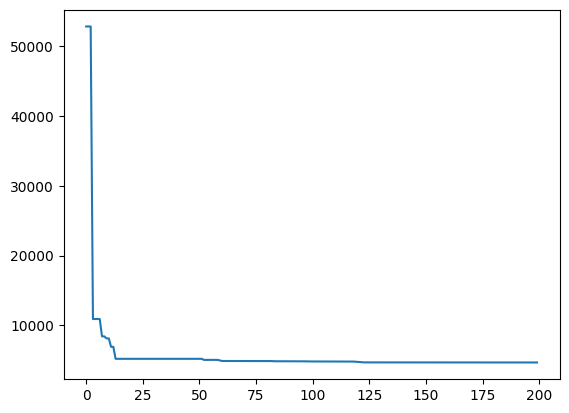

In [17]:
plt.plot(optimizer.cost_history)
plt.show()


In [18]:
vid_no_var = 0
file_name = f"pyswarms_outputs/out_{vid_no_var}.pickle"


def optimizer_pickler(obj) -> dict:
    global vid_no_var
    while 1:
        file_name = f"pyswarms_outputs/out_{vid_no_var}.pickle"
        if not os.path.exists(file_name):
            optimizer_dict = {
                attr: getattr(obj, attr)
                for attr in [
                    "bounds",
                    "center",
                    "cost_history",
                    "dimensions",
                    "ftol",
                    "ftol_iter",
                    "init_pos",
                    "mean_neighbor_history",
                    "mean_pbest_history",
                    "n_particles",
                    "name",
                    "options",
                    "pos_history",
                    "swarm",
                    "swarm_size",
                    "velocity_clamp",
                    "velocity_history",
                ]
            }

            optimizer_dict["best_pos_history"] = np.array(best_pos_history)
            optimizer_dict["gals_grp"] = gals_grp

            with open(file_name, "wb") as picky:
                pickle.dump(optimizer_dict, picky)
            break
        vid_no_var += 1
    return optimizer_dict

optimizer_dict = optimizer_pickler(optimizer)


In [19]:
a, b, c = (
    optimizer_dict["best_pos_history"][-1][:num_grp] / (1e11 * m0),
    optimizer_dict["best_pos_history"][-1][num_grp : 2 * num_grp],
    optimizer_dict["best_pos_history"][-1][
        2 * num_grp : 2 * num_grp + num_bulges_in_grp
    ],
)
a, b, c

(array([637.30622549, 368.56964217, 698.53558106, 853.50565844,
        418.39016338, 548.32858356, 310.62644599, 117.4055038 ,
        464.83415502, 397.22140176]),
 array([0.62987617, 0.73236009, 0.57775883, 0.66003363, 0.76166611,
        0.55421987, 0.74055532, 0.40710672, 0.48362321, 0.75023727]),
 array([0.44587326]))

2023-11-14 16:08:43,712 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


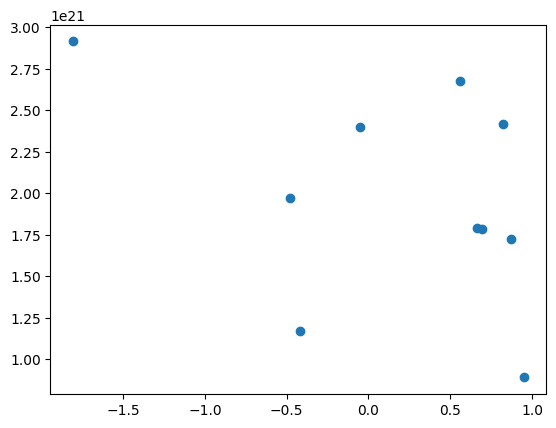

In [20]:
# matplotlib.use("Agg")  # Use a non-interactive backend
pickle_open_no = vid_no_var

with open(f"pyswarms_outputs/out_{pickle_open_no}.pickle", "rb") as picky:
    optimizer_dict = pickle.load(picky)

x, y = (
    optimizer_dict["pos_history"][0].transpose()[-2],
    optimizer_dict["pos_history"][0].transpose()[-1],
)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y)


def update(frame):
    scatter.set_offsets(
        np.column_stack(
            (
                optimizer_dict["pos_history"][frame].transpose()[-2],
                optimizer_dict["pos_history"][frame].transpose()[-1],
            )
        )
    )


anim = FuncAnimation(
    fig, update, frames=len(optimizer_dict["velocity_history"]), repeat=False
)
HTML(anim.to_jshtml())

In [21]:
# print("beta =", optimizer_dict["best_pos_history"][-1, -2])
# print("lambda =", optimizer_dict["best_pos_history"][-1, -1] / kpc, "kpc")

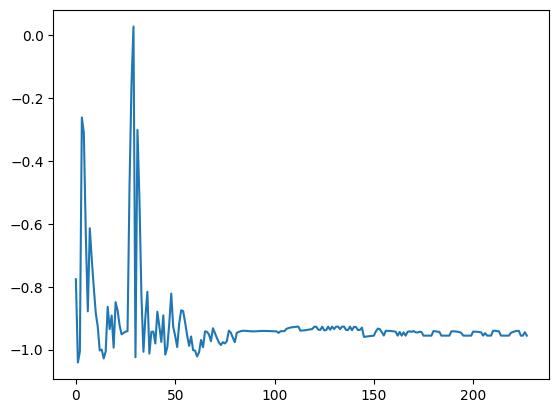

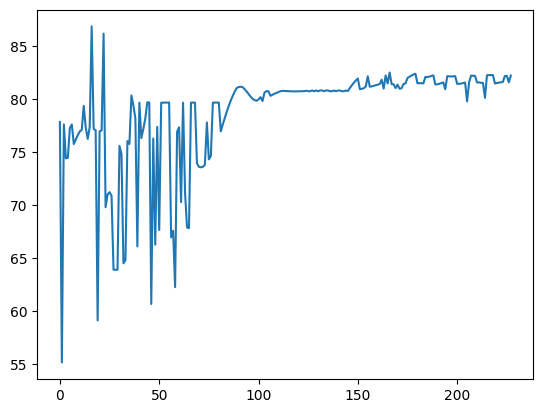

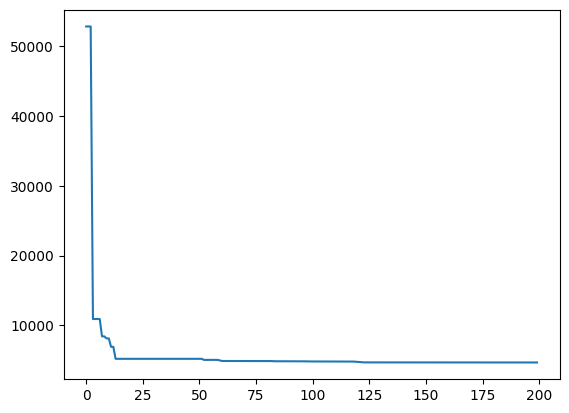

In [22]:
plt.figure()
plt.plot(np.array((optimizer_dict["best_pos_history"]))[:, -2])
plt.figure()
plt.plot(np.array((optimizer_dict["best_pos_history"]))[:, -1] / kpc)
plt.figure()
plt.plot(np.array((optimizer_dict["cost_history"])))
plt.show()

In [23]:
paper_sol = (
    (np.array([2.91, 1.63, 3.79, 0.76, 4.3, 12, 1.9, 8.64, 8.85, 3.39]) * 1e11 * m0).tolist()+[0.6, 0.79, 0.64, 0.32, 0.40, 0.49, 0.33, 0.46, .36, .62]+[0.52]
    + ([0.34, 10.27 * kpc] if INCLUDE_MG else [])
)

found_sols = []
for i in range(10):
    try:
        with open(f"pyswarms_outputs/out_{i}.pickle", "rb") as picky:
            solly = pickle.load(picky)
            found_sols.append(solly["best_pos_history"][-1])
    except:
        break
PSO_cost([paper_sol]+found_sols)

TypeError: 'numpy.ndarray' object is not callable

# Overnight

In [ ]:
'''craze_liss = []

b_diff = 4/10
l_diff = (100-lam_0_bar)/10

for b in np.arange(-2, 2, b_diff):
    for l in np.arange(lam_0_bar, 100, l_diff):
        g_best = np.inf
        best_pos_history = []

        def PSO_cost(particles: np.ndarray):
            global g_best
            if PRINT_NEGA_POSI:
                global nega, posi
                print(nega, posi, sep="\t", end="\t\t\r")
                nega, posi = 0, 0

            temp = -np.array([log_likelihood_total(particle) for particle in particles])
            argy = np.argmin(temp)


            if g_best > temp[argy]:
                best_pos_history.append(particles[argy])
            else:
                best_pos_history.append(best_pos_history[-1])
                g_best = temp[argy]
            return temp

            # instatiate the optimizer

        x_min = np.hstack(
            (
                m0 * np.full(num_grp, 1e9),
                np.full(num_grp + num_bulges_in_grp, 0.3),
                [b, l * kpc],
            )
        )
        x_max = np.hstack(
            (
                m0 * np.full(num_grp, 1e14),
                np.full(num_grp + num_bulges_in_grp, 0.8),
                [b+b_diff, (l+l_diff)*kpc],
            )
        )

        bounds = (x_min, x_max)
        options = {"c1": 0.5, "c2": 0.3, "w": 0.9}

        iters = 150
        n_particles = 10

        # Call instance of GlobalBestPSO
        optimizer = ps.single.GlobalBestPSO(
            n_particles=n_particles, dimensions=2 + 2 * num_grp+num_bulges_in_grp, options=options, bounds=bounds
        )

        # Perform optimization
        stats = optimizer.optimize(PSO_cost, iters=iters)

        optimizer_dict = {
                attr: getattr(optimizer, attr)
                for attr in [
                    "bounds",
                    "center",
                    "cost_history",
                    "dimensions",
                    "ftol",
                    "ftol_iter",
                    "init_pos",
                    "mean_neighbor_history",
                    "mean_pbest_history",
                    "n_particles",
                    "name",
                    "options",
                    "pos_history",
                    "swarm",
                    "swarm_size",
                    "velocity_clamp",
                    "velocity_history",
                ]
            }

        optimizer_dict["best_pos_history"] = np.array(best_pos_history)
        optimizer_dict["gals_grp"] = gals_grp
        craze_liss.append(optimizer_dict)


with open('pyswarms_outputs/meoww.pickle', 'wb') as picky:
    pickle.dump(craze_liss, picky)'''

'craze_liss = []\n\nb_diff = 4/10\nl_diff = (100-lam_0_bar)/10\n\nfor b in np.arange(-2, 2, b_diff):\n    for l in np.arange(lam_0_bar, 100, l_diff):\n        g_best = np.inf\n        best_pos_history = []\n\n        def PSO_cost(particles: np.ndarray):\n            global g_best\n            if PRINT_NEGA_POSI:\n                global nega, posi\n                print(nega, posi, sep="\t", end="\t\t\r")\n                nega, posi = 0, 0\n\n            temp = -np.array([log_likelihood_total(particle) for particle in particles])\n            argy = np.argmin(temp)\n\n\n            if g_best > temp[argy]:\n                best_pos_history.append(particles[argy])\n            else:\n                best_pos_history.append(best_pos_history[-1])\n                g_best = temp[argy]\n            return temp\n\n            # instatiate the optimizer\n\n        x_min = np.hstack(\n            (\n                m0 * np.full(num_grp, 1e9),\n                np.full(num_grp + num_bulges_in_grp, 

In [ ]:
their = []
for i in range()

SyntaxError: invalid syntax (930864305.py, line 2)